<a href="https://colab.research.google.com/github/pckuo/dale-regression/blob/main/playground_pck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install qpsolvers[open_source_solvers]

In [44]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
from qpsolvers import solve_ls
import time
import pickle
# import jax.numpy as jnp
# from jax import grad, random, lax

### Train a Linear Perceptron with Quadratic Programming

In [50]:
SEED = 42

# simulation
# N = 10000         # n_neuorns
# alpha = 1         # proportional limit
noise_coeff = 0.01  # noise_level
n_runs = 5         # n_runs per N

alphas = np.arange(0.1, 2.025, 0.025)
# Ns = np.logspace(2,4, num=4)
Ns = np.array([2000])
gammas = np.arange(0, 1.1, 0.1)

In [4]:
# set seed
np.random.seed(SEED)

results_dict = {}

for gamma in gammas:
  for N in Ns:
    for alpha in alphas:
      print(f'alpha {alpha}, N {N}, gamma {gamma}')
      P = int(alpha * N)

      # save results
      results_dict_alpha_N_gamma = {
          'w_student': [],
          'mean_error_w': [],
          'mse_w': [],
          'mean_w_teacher_sq': [],
          'mean_w_student_sq': [],
          'mean_scalar_product_w_teacher_student': []
      }

      start = time.time()
      for run_id in range(n_runs):
        # teacher weights
        w_teacher = np.random.normal(size=int(N))

        # data
        X = np.random.normal(size=(P, int(N)))
        eps = noise_coeff * np.random.normal(size=P)
        y = 1/np.sqrt(N) * X @ w_teacher + eps

        # solve with sklearn linear regression
        # reg_nnls = LinearRegression(positive=True)
        # w_student_sk = reg_nnls.fit(X, y).coef_

        # solve with quadratic programming
        constrained_dim = int(gamma*N)
        unconstrained_dim = N - constrained_dim
        I = -1*np.eye(constrained_dim)
        G = np.block([
            [I, np.zeros((constrained_dim, unconstrained_dim))],
            [np.zeros((unconstrained_dim, constrained_dim)), np.zeros((unconstrained_dim, unconstrained_dim))]
        ])
        w_student = solve_ls(
          R=1/np.sqrt(N)*X,
          s=y,
          G=G,
          h=np.zeros(int(N)),
          solver="osqp"
        )
        # solver: osqp: 6min/ 9G for N=1e4
        # solver: quadprog: >15min/ 6G for N=1e4
        # solver: cvxopt: >11min/ 6G for N=1e4

        # compute errors
        # mean_error_w_sk = np.sum((w_student_sk - w_teacher))/ N
        mean_error_w = np.sum((w_student - w_teacher))/ N
        mse_w = np.sum((w_student - w_teacher)**2)/ N
        mean_w_teacher_sq = np.sum(w_teacher**2)/ N
        mean_w_student_sq = np.sum(w_student**2)/ N
        mean_scalar_product_w_teacher_student = np.sum(w_student * w_teacher)/ N

        # save results
        results_dict_alpha_N_gamma['w_student'].append(w_student)
        results_dict_alpha_N_gamma['mean_error_w'].append(mean_error_w)
        results_dict_alpha_N_gamma['mse_w'].append(mse_w)
        results_dict_alpha_N_gamma['mean_w_teacher_sq'].append(mean_w_teacher_sq)
        results_dict_alpha_N_gamma['mean_w_student_sq'].append(mean_w_student_sq)
        results_dict_alpha_N_gamma['mean_scalar_product_w_teacher_student'].append(mean_scalar_product_w_teacher_student)

      end = time.time()
      print(f' elapsed time: {end - start}')
      print(f' mse_w: {results_dict_alpha_N_gamma["mse_w"]}')

      for k, v in results_dict_alpha_N_gamma.items():
        results_dict_alpha_N_gamma[k] = np.array(v)

      results_dict[(alpha, int(N), gamma)] = results_dict_alpha_N_gamma


with open('./result_dict.pkl', 'wb') as f:
  pickle.dump(results_dict, f)

alpha 1.0, N 2000, gamma 0.0


/usr/local/lib/python3.10/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


 elapsed time: 17.755202531814575
 mse_w: [0.16160015505297506, 0.11134149218677769, 0.35396039880284275]
alpha 0.975, N 2000, gamma 0.0
 elapsed time: 10.070661306381226
 mse_w: [0.035438423876083834, 0.027231893904956877, 0.029107087378956686]
alpha 1.025, N 2000, gamma 0.0
 elapsed time: 10.897682905197144
 mse_w: [0.005086712439093129, 0.0039340086567214, 0.003613903431081841]
alpha 0.95, N 2000, gamma 0.0
 elapsed time: 10.59195590019226
 mse_w: [0.0546075523556838, 0.05187629061849455, 0.045292731047014215]
alpha 1.05, N 2000, gamma 0.0
 elapsed time: 10.591421365737915
 mse_w: [0.0018435952066186184, 0.002274821510009419, 0.002770787560550188]
alpha 0.6, N 2000, gamma 0.0
 elapsed time: 9.95019817352295
 mse_w: [0.38820089347911996, 0.3887884268327668, 0.4075679327743784]
alpha 0.7, N 2000, gamma 0.0
 elapsed time: 9.759997844696045
 mse_w: [0.2947371086678511, 0.27957953912321193, 0.29600394737463154]
alpha 0.8, N 2000, gamma 0.0
 elapsed time: 11.630239725112915
 mse_w: [0.184

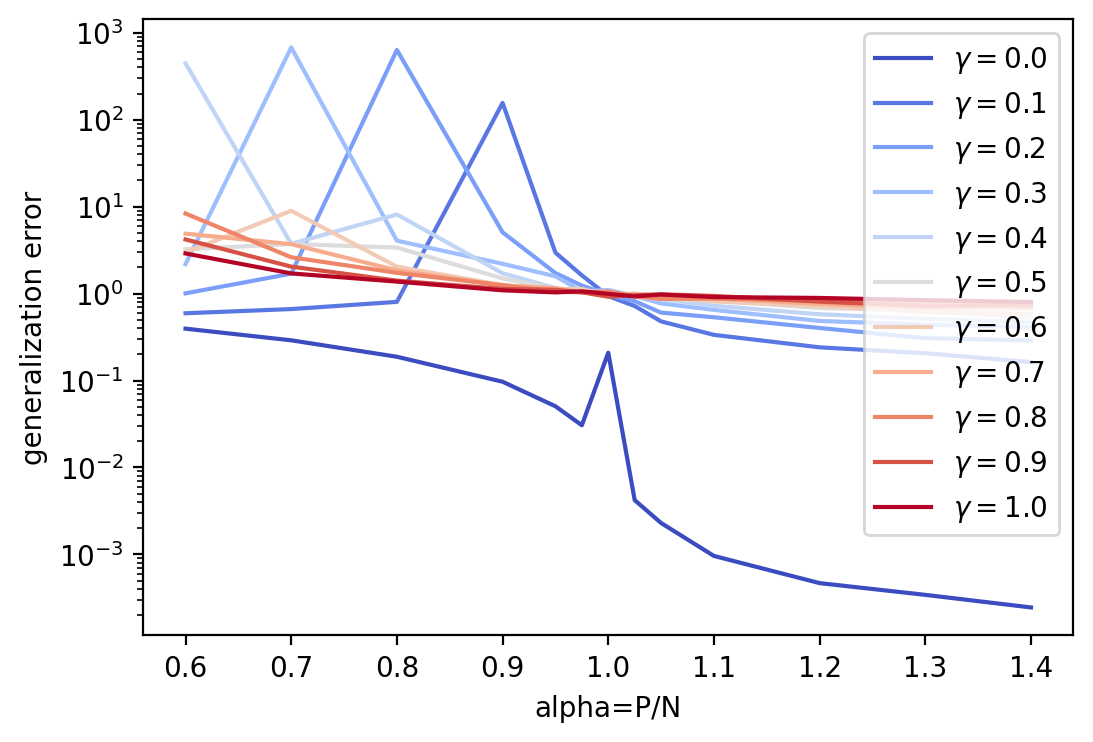

In [21]:
import matplotlib as mpl

metric = 'mse_w'

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
for gamma_id, gamma in enumerate(gammas):
  mean_metric = []
  for alpha in np.sort(alphas):
    mean_metric.append(np.mean(results_dict[(alpha, int(N), gamma)][metric]))

  scatter = ax.plot(
      np.sort(alphas),
      mean_metric,
      label=f'$\gamma={gamma:.1f}$',
      c=mpl.colormaps['coolwarm'](gamma/np.max(gammas))
  )
ax.set_xlabel('alpha=P/N')
ax.set_ylabel('generalization error')
ax.set_yscale('log')
ax.legend()



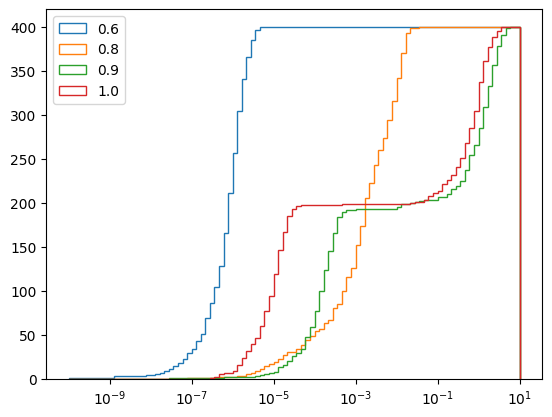

In [41]:
gamma = 0.2
N_cutoff = int(N * gamma)

for alpha in [0.6, 0.8, 0.9, 1.0]:
  # plt.hist(results_dict[(alpha, int(N), gamma)]['w_student'][0][:N_cutoff], bins=np.linspace(-1, 8, 20), histtype='step', label=f'{alpha}')
  plt.hist(abs(results_dict[(alpha, int(N), gamma)]['w_student'][0][:N_cutoff]), bins=np.logspace(-10, 1, 100), histtype='step', label=f'{alpha}', cumulative=True)
  # plt.hist(results_dict[(alpha, int(N), gamma)]['w_student'][0][N_cutoff:], histtype='step')
plt.xscale('log')
plt.legend()

<ipython-input-14-e3207b7fe02e>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


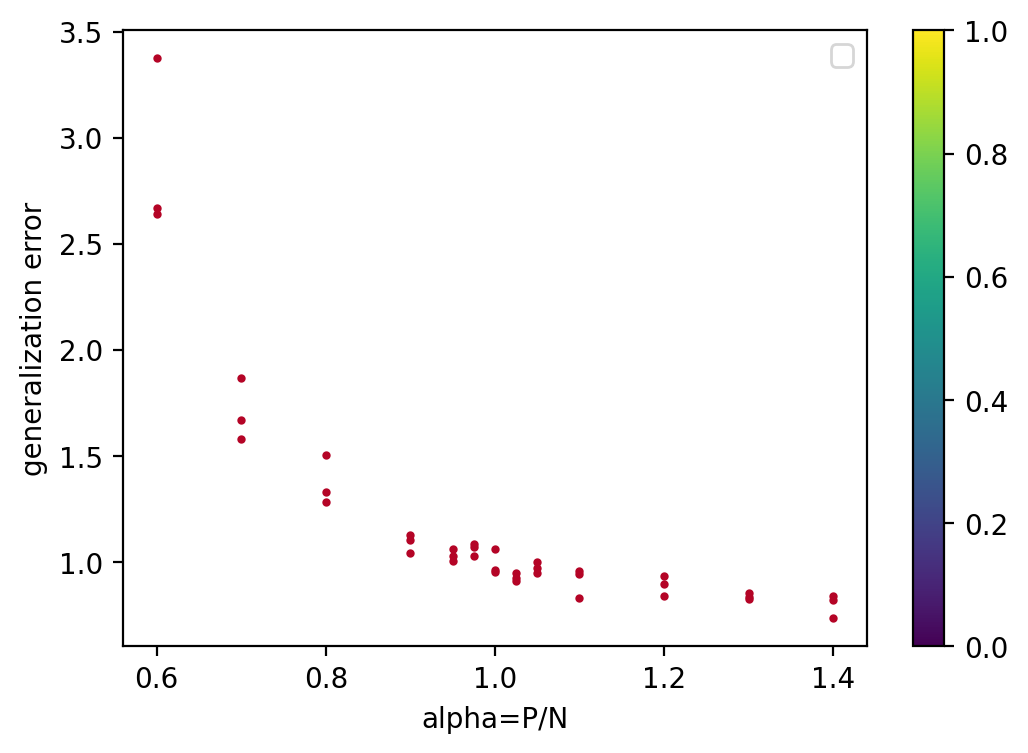

In [14]:
metric = 'mse_w'

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
gamma = 1
for alpha in alphas:
  scatter = ax.scatter(
      [alpha]*n_runs,
      results_dict[(alpha, int(N), gamma)][metric],
      c=mpl.colormaps['coolwarm'](gamma/np.max(gammas)),
      s=4
  )
ax.set_xlabel('alpha=P/N')
ax.set_ylabel('generalization error')
# ax.set_yscale('log')
ax.legend()
fig.colorbar(scatter)



In [10]:
# MSE
print(f'mean_error_w: {mean_error_w}')
print(f'mse_w: {mse_w}')
# print(f'mean_w_teacher_sq: {mean_w_teacher_sq}')
# print(f'mean_w_student_sq: {mean_w_student_sq}')
# print(f'mean_scalar_product_w_teacher_student: {mean_scalar_product_w_teacher_student}')

mean_error_w: 0.5818401061397249
mse_w: 1.0168924646503388


In [ ]:
plt.plot(w_student - w_teacher)

In [ ]:
alpha = 1.25
for N in Ns:
  plt.hist(
      results_dict[(alpha, int(N))]['w_student'][0],
      bins=np.linspace(-2,5,20),
      density=True,
      histtype='step',
      label=f'{N}'
  )
plt.legend()

In [42]:
with open('./result_dict_alpha_gamma.pkl', 'wb') as f:
  pickle.dump(results_dict, f)

In [43]:
from google.colab import files
files.download( "./result_dict_alpha_gamma.pkl" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>